In [8]:
import time
import numpy as np
import scipy.sparse, scipy.sparse.linalg, scipy.spatial.distance
from sklearn import datasets, linear_model
import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys
sys.path.append('Z:\EDUCATION\SEM -2\Research Practice\Codes\cnn_graph-master')
from lib import graph

In [9]:
import numpy as np
import pandas as pd

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt
import time
import copy
from random import shuffle

In [10]:
import cv2
COVID_PATH = 'Z:/EDUCATION/SEM -2/Research Practice/Codes/dataset/train/covid'
NORMAL_PATH = 'Z:/EDUCATION/SEM -2/Research Practice/Codes/dataset/train/normal'
fig = plt.figure(figsize=(16,5))
fig.suptitle("COVID19 Positive", size=22)
img_paths = os.listdir(COVID_PATH)
shuffle(img_paths)

X = np.empty((2500, 2,600))
cou=0;
dim = (50,50)
for i,image in enumerate(img_paths):
    img = cv2.imread(os.path.join(COVID_PATH, image))
    resized = cv2.resize(img,dim, interpolation = cv2.INTER_AREA)
    X[:,0,cou]=resized[:,:,0].ravel()
    cou=cou+1
    if cou>=600:
        break

<Figure size 1152x360 with 0 Axes>

In [11]:
img_paths = os.listdir(NORMAL_PATH)
shuffle(img_paths)
cou=0;
for i,image in enumerate(img_paths):
    img = cv2.imread(os.path.join(NORMAL_PATH, image))
    resized = cv2.resize(img,dim, interpolation = cv2.INTER_AREA)
    X[:,1,cou]=resized[:,:,0].ravel()
    cou=cou+1
    if cou>=600:
        break

In [12]:
X1=X
M=2500
N=600
y = np.empty((2,600))
y[0,:] = -1
y[1,:] = +1
X.shape = M, 2*N
y.shape = 2*N, 1

(2500, 1200)
Dimensionality: N=1200 samples, M=2500 features
X in [-127.5, 127.5]


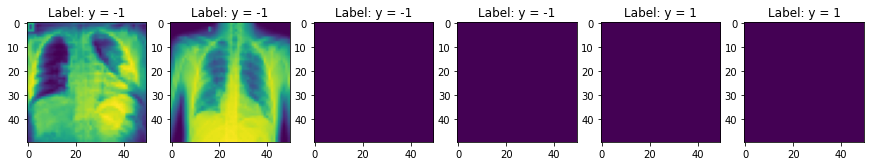

In [13]:
print(np.shape(X))


print('Dimensionality: N={} samples, M={} features'.format(X.shape[1], X.shape[0]))

X -= 127.5
print('X in [{}, {}]'.format(np.min(X), np.max(X)))

def plot_digit(nn):
    M, N = X.shape
    m = int(np.sqrt(M))
    fig, axes = plt.subplots(1,len(nn), figsize=(15,5))
    for i, n in enumerate(nn):
        n = int(n)
        img = X[:,n]
        axes[i].imshow(img.reshape((m,m)))
        axes[i].set_title('Label: y = {:.0f}'.format(y[n,0]))

plot_digit([0, 1, 1e2, 1e2+1, 1e3, 1e3+1])

In [14]:
def test_sklearn(tauR):
    
    def L(w, b=0):
        return np.linalg.norm(X.T @ w + b - y)**2 + tauR * np.linalg.norm(w)**2

    def dL(w):
        return 2 * X @ (X.T @ w - y) + 2 * tauR * w

    clf = linear_model.Ridge(alpha=tauR, fit_intercept=False)
    clf.fit(X.T, y)
    w = clf.coef_.T

    print('L = {}'.format(L(w, clf.intercept_)))
    print('|dLw| = {}'.format(np.linalg.norm(dL(w))))

    # Normalized data: intercept should be small.
    print('bias: {}'.format(abs(np.mean(y - X.T @ w))))

test_sklearn(1e-3)

L = 1104.4437427145583
|dLw| = 187098.5272356163
bias: 0.012195457312336656


In [15]:
def test_optim(clf, X, y, ax=None):
    """Test optimization on full dataset."""
    tstart = time.process_time()
    ret = clf.fit(X, y)
    print('Processing time: {}'.format(time.process_time()-tstart))
    print('L = {}'.format(clf.L(*ret, y)))
    if hasattr(clf, 'dLc'):
        print('|dLc| = {}'.format(np.linalg.norm(clf.dLc(*ret, y))))
    if hasattr(clf, 'dLw'):
        print('|dLw| = {}'.format(np.linalg.norm(clf.dLw(*ret, y))))
    if hasattr(clf, 'loss'):
        if not ax:
            fig = plt.figure()
            ax = fig.add_subplot(111)
        ax.semilogy(clf.loss)
        ax.set_title('Convergence')
        ax.set_xlabel('Iteration number')
        ax.set_ylabel('Loss')
    if hasattr(clf, 'Lsplit'):
        print('Lsplit = {}'.format(clf.Lsplit(*ret, y)))
        print('|dLz| = {}'.format(np.linalg.norm(clf.dLz(*ret, y))))
        ax.semilogy(clf.loss_split)

In [16]:
class rls:
    
    def __init__(s, tauR, algo='solve'):
        s.tauR = tauR
        if algo is 'solve':
            s.fit = s.solve
        elif algo is 'inv':
            s.fit = s.inv

    def L(s, X, y):
        return np.linalg.norm(X.T @ s.w - y)**2 + s.tauR * np.linalg.norm(s.w)**2

    def dLw(s, X, y):
        return 2 * X @ (X.T @ s.w - y) + 2 * s.tauR * s.w
    
    def inv(s, X, y):
        s.w = np.linalg.inv(X @ X.T + s.tauR * np.identity(X.shape[0])) @ X @ y
        return (X,)
    
    def solve(s, X, y):
        s.w = np.linalg.solve(X @ X.T + s.tauR * np.identity(X.shape[0]), X @ y)
        return (X,)
    
    def predict(s, X):
        return X.T @ s.w

test_optim(rls(1e-3, 'solve'), X, y)
test_optim(rls(1e-3, 'inv'), X, y)

<>:5: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:7: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:5: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:7: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\NITHISH\AppData\Local\Temp\ipykernel_1388\1503132113.py:5: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if algo is 'solve':
C:\Users\NITHISH\AppData\Local\Temp\ipykernel_1388\1503132113.py:7: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif algo is 'inv':


Processing time: 1.828125
L = 1104.2495479360946
|dLw| = 1.2525016557640423e-08
Processing time: 5.6875
L = 1104.2510622370348
|dLw| = 226.0163174430315


In [17]:
t_start = time.process_time()
z = graph.grid(int(np.sqrt(X.shape[0])))
dist, idx = graph.distance_sklearn_metrics(z, k=4)
A = graph.adjacency(dist, idx)
L = graph.laplacian(A, True)
lmax = graph.lmax(L)
print('Execution time: {:.2f}s'.format(time.process_time() - t_start))

Execution time: 1.48s


In [18]:
def lanczos(L, X, K):
    M, N = X.shape
    a = np.empty((K, N))
    b = np.zeros((K, N))
    V = np.empty((K, M, N))
    V[0,...] = X / np.linalg.norm(X, axis=0)
    for k in range(K-1):
        W = L.dot(V[k,...])
        a[k,:] = np.sum(W * V[k,...], axis=0)
        W = W - a[k,:] * V[k,...] - (b[k,:] * V[k-1,...] if k>0 else 0)
        b[k+1,:] = np.linalg.norm(W, axis=0)
        V[k+1,...] = W / b[k+1,:]
    a[K-1,:] = np.sum(L.dot(V[K-1,...]) * V[K-1,...], axis=0)
    return V, a, b

def lanczos_H_diag(a, b):
    K, N = a.shape
    H = np.zeros((K*K, N))
    H[:K**2:K+1, :] = a
    H[1:(K-1)*K:K+1, :] = b[1:,:]
    H.shape = (K, K, N)
    Q = np.linalg.eigh(H.T, UPLO='L')[1]
    Q = np.swapaxes(Q,1,2).T
    return Q

def lanczos_basis_eval(L, X, K):
    V, a, b = lanczos(L, X, K)
    Q = lanczos_H_diag(a, b)
    M, N = X.shape
    Xt = np.empty((K, M, N))
    for n in range(N):
        Xt[...,n] = Q[...,n].T @ V[...,n]
    Xt *= Q[0,:,np.newaxis,:]
    Xt *= np.linalg.norm(X, axis=0)
    return Xt, Q[0,...]

In [19]:
def test():
    """Test the speed of filtering and weighting."""
    
    def mult(impl=3):
        if impl == 0:
            Xb = Xt.view()
            Xb.shape = (K, M*N)
            XCb = Xb.T @ C  # in MN x F
            XCb = XCb.T.reshape((F*M, N))
            return (XCb.T @ w).squeeze()
        elif impl == 1:
            tmp = np.tensordot(Xt, C, (0,0))
            return np.tensordot(tmp, W, ((0,2),(1,0)))
        elif impl == 2:
            tmp = np.tensordot(Xt, C, (0,0))
            return np.einsum('ijk,ki->j', tmp, W)
        elif impl == 3:
            return np.einsum('kmn,fm,kf->n', Xt, W, C)
    
    C = np.random.normal(0,1,(K,F))
    W = np.random.normal(0,1,(F,M))
    w = W.reshape((F*M, 1))
    a = mult(impl=0)
    for impl in range(4):
        tstart = time.process_time()
        for k in range(1000):
            b = mult(impl)
        print('Execution time (impl={}): {}'.format(impl, time.process_time() - tstart))
        np.testing.assert_allclose(a, b)
#test()

In [20]:
class gflc_noweights:

    def __init__(s, F, K, niter, algo='direct'):
        """Model hyper-parameters"""
        s.F = F
        s.K = K
        s.niter = niter
        if algo == 'direct':
            s.fit = s.direct
        elif algo == 'sgd':
            s.fit = s.sgd
    
    def L(s, Xt, y):
        #tmp = np.einsum('kmn,kf,fm->n', Xt, s.C, np.ones((s.F,M))) - y.squeeze()
        #tmp = np.einsum('kmn,kf->mnf', Xt, s.C).sum((0,2)) - y.squeeze()
        #tmp = (C.T @ Xt.reshape((K,M*N))).reshape((F,M,N)).sum((0,2)) - y.squeeze()
        tmp = np.tensordot(s.C, Xt, (0,0)).sum((0,1)) - y.squeeze()
        return np.linalg.norm(tmp)**2

    def dLc(s, Xt, y):
        tmp = np.tensordot(s.C, Xt, (0,0)).sum(axis=(0,1)) - y.squeeze()
        return np.dot(Xt, tmp).sum(1)[:,np.newaxis].repeat(s.F,1)
        #return np.einsum('kmn,n->km', Xt, tmp).sum(1)[:,np.newaxis].repeat(s.F,1)

    def sgd(s, X, y):
        Xt, q = lanczos_basis_eval(L, X, s.K)
        s.C = np.random.normal(0, 1, (s.K, s.F))
        s.loss = [s.L(Xt, y)]
        for t in range(s.niter):
            s.C -= 1e-13 * s.dLc(Xt, y)
            s.loss.append(s.L(Xt, y))
        return (Xt,)
    
    def direct(s, X, y):
        M, N = X.shape
        Xt, q = lanczos_basis_eval(L, X, s.K)
        s.C = np.random.normal(0, 1, (s.K, s.F))
        W = np.ones((s.F, M))
        c = s.C.reshape((s.K*s.F, 1))
        s.loss = [s.L(Xt, y)]
        Xw = np.einsum('kmn,fm->kfn', Xt, W)
        #Xw = np.tensordot(Xt, W, (1,1))
        Xw.shape = (s.K*s.F, N)
        #np.linalg.inv(Xw @ Xw.T)
        c[:] = np.linalg.solve(Xw @ Xw.T, Xw @ y)
        s.loss.append(s.L(Xt, y))
        return (Xt,)

In [21]:
class gflc_weights():

    def __init__(s, F, K, tauR, niter, algo='direct'):
        """Model hyper-parameters"""
        s.F = F
        s.K = K
        s.tauR = tauR
        s.niter = niter
        if algo is 'direct':
            s.fit = s.direct
        elif algo is 'sgd':
            s.fit = s.sgd

    def L(s, Xt, y):
        tmp = np.einsum('kmn,kf,fm->n', Xt, s.C, s.W) - y.squeeze()
        return np.linalg.norm(tmp)**2 + s.tauR * np.linalg.norm(s.W)**2

    def dLw(s, Xt, y):
        tmp = np.einsum('kmn,kf,fm->n', Xt, s.C, s.W) - y.squeeze()
        return 2 * np.einsum('kmn,kf,n->fm', Xt, s.C, tmp) + 2 * s.tauR * s.W

    def dLc(s, Xt, y):
        tmp = np.einsum('kmn,kf,fm->n', Xt, s.C, s.W) - y.squeeze()
        return 2 * np.einsum('kmn,n,fm->kf', Xt, tmp, s.W)

    def sgd(s, X, y):
        M, N = X.shape
        Xt, q = lanczos_basis_eval(L, X, s.K)
        s.C = np.random.normal(0, 1, (s.K, s.F))
        s.W = np.random.normal(0, 1, (s.F, M))

        s.loss = [s.L(Xt, y)]

        for t in range(s.niter):
            s.C -= 1e-12 * s.dLc(Xt, y)
            s.W -= 1e-12 * s.dLw(Xt, y)
            s.loss.append(s.L(Xt, y))
        
        return (Xt,)
    def direct(s, X, y):
        M, N = X.shape
        Xt, q = lanczos_basis_eval(L, X, s.K)
        s.C = np.random.normal(0, 1, (s.K, s.F))
        s.W = np.random.normal(0, 1, (s.F, M))
        #c = s.C.reshape((s.K*s.F, 1))
        #w = s.W.reshape((s.F*M, 1))
        c = s.C.view()
        c.shape = (s.K*s.F, 1)
        w = s.W.view()
        w.shape = (s.F*M, 1)

        s.loss = [s.L(Xt, y)]

        for t in range(s.niter):
            Xw = np.einsum('kmn,fm->kfn', Xt, s.W)
            #Xw = np.tensordot(Xt, s.W, (1,1))
            Xw.shape = (s.K*s.F, N)
            c[:] = np.linalg.solve(Xw @ Xw.T, Xw @ y)

            Z = np.einsum('kmn,kf->fmn', Xt, s.C)
            #Z = np.tensordot(Xt, s.C, (0,0))
            #Z = s.C.T @ Xt.reshape((K,M*N))
            Z.shape = (s.F*M, N)
            w[:] = np.linalg.solve(Z @ Z.T + s.tauR * np.identity(s.F*M), Z @ y)

            s.loss.append(s.L(Xt, y))
        
        return (Xt,)

    def predict(s, X):
        Xt, q = lanczos_basis_eval(L, X, s.K)
        return np.einsum('kmn,kf,fm->n', Xt, s.C, s.W)
     

<>:9: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:11: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:9: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:11: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\NITHISH\AppData\Local\Temp\ipykernel_1388\3256124402.py:9: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if algo is 'direct':
C:\Users\NITHISH\AppData\Local\Temp\ipykernel_1388\3256124402.py:11: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif algo is 'sgd':


In [22]:
Xt, q = lanczos_basis_eval(L, X, 50)

In [23]:
np.shape(Xt)

(50, 2500, 1200)

In [24]:
Xt1=Xt.reshape((1200,50,2500))

In [25]:
np.shape(Xt1)

(1200, 50, 2500)

In [26]:
np.shape(y)

(1200, 1)

In [27]:
perm = np.arange(y.shape[0])
np.random.shuffle(perm)

In [28]:
y=y[perm]
Xt1=Xt1[perm,:,:]

In [53]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout,LSTM,MaxPool2D,Flatten
from keras.layers.convolutional import Conv2D
from keras import regularizers
noe=5
def model1(X_train,y_train,X_test):
    model = Sequential()
    model.add(LSTM(units = 256, return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 128, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 64))
    model.add(Dropout(0.2))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs = noe, batch_size = 10)
    Y_pred = model.predict(X_test)
    return Y_pred.reshape(1,-1),model

In [30]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
yp=np.zeros((y.shape[0]))
for train_index, test_index in kf.split(Xt1):
    X_train=Xt1[train_index,:,:]
    y_train=y[train_index]
    X_test=Xt1[test_index,:,:]
    y_test=y[test_index]
    #m1=model3(X_train,y_train)
    #yp[test_index]=m1.predict(X_test)
    yp[test_index],m1=model1(X_train,y_train,X_test)

Epoch 1/5
96/96 [==============================] - 51s 447ms/step - loss: -4.4752 - accuracy: 0.4250
Epoch 2/5
96/96 [==============================] - 43s 447ms/step - loss: -8.0867 - accuracy: 0.4521
Epoch 3/5
96/96 [==============================] - 43s 445ms/step - loss: -10.9027 - accuracy: 0.4635
Epoch 4/5
96/96 [==============================] - 43s 449ms/step - loss: -13.9297 - accuracy: 0.4750
Epoch 5/5
96/96 [==============================] - 43s 447ms/step - loss: -15.0147 - accuracy: 0.4563
Epoch 1/5
96/96 [==============================] - 49s 445ms/step - loss: -3.1282 - accuracy: 0.4083
Epoch 2/5
96/96 [==============================] - 43s 445ms/step - loss: -7.8293 - accuracy: 0.4677
Epoch 3/5
96/96 [==============================] - 43s 446ms/step - loss: -11.2318 - accuracy: 0.4875
Epoch 4/5
96/96 [==============================] - 41s 431ms/step - loss: -12.8201 - accuracy: 0.4740
Epoch 5/5
96/96 [==============================] - 41s 431ms/step - loss: -16.5932 - a

In [31]:
in0=np.where(y==-1)
y[in0[0]]=0

In [32]:
from sklearn.metrics import confusion_matrix
ino=np.where(yp>=0)
in1=np.where(yp<0)
yp1=np.zeros((y.shape[0]))
yp1[ino]=1
yp1[in1]=-1
confusion_matrix(y,yp1)

array([[  0, 600],
       [  0, 600]], dtype=int64)

In [54]:
model = Sequential()
model.add(Conv2D(filters = 32, padding = "same",activation = "relu",kernel_size=3, strides = 2,input_shape=(64,64,3)))
model.add(MaxPool2D(pool_size=(2,2),strides = 2))

model.add(Conv2D(filters = 32, padding = "same",activation = "relu",kernel_size=3))
model.add(MaxPool2D(pool_size=(2,2),strides = 2))

model.add(Flatten())
model.add(Dense(128,activation="relu"))

#Output layer
model.add(Dense(1,kernel_regularizer=regularizers.l2(0.01),activation = "linear"))

Processing time: 391.125
L = 276.50000000001523
|dLc| = 5.939982147647367e-17
|dLw| = 0.00011437269161749012


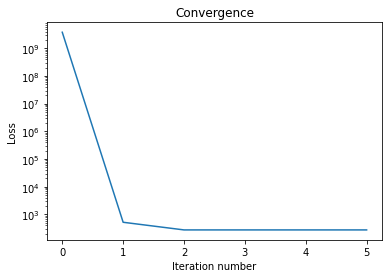

In [55]:
clf_weights = gflc_weights(F=3, K=50, tauR=1e4, niter=5, algo='direct')
test_optim(clf_weights, X, y)

<>:10: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:10: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\NITHISH\AppData\Local\Temp\ipykernel_1388\3234331456.py:10: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if algo is 'direct':
C:\Users\NITHISH\AppData\Local\Temp\ipykernel_1388\3234331456.py:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif algo is 'sgd':


Processing time: 533.15625
L = 370.8092261708295
|dLc| = 3078.4235242884124
|dLw| = 3.205764740453259e-11
Lsplit = 103.81389228479894
|dLz| = 0.08061849835530346


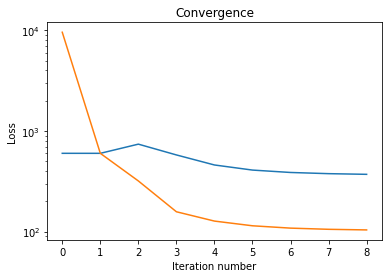

In [56]:
class gflc_split():

    def __init__(s, F, K, tauR, tauF, niter, algo='direct'):
        """Model hyper-parameters"""
        s.F = F
        s.K = K
        s.tauR = tauR
        s.tauF = tauF
        s.niter = niter
        if algo is 'direct':
            s.fit = s.direct
        elif algo is 'sgd':
            s.fit = s.sgd

    def L(s, Xt, XCb, Z, y):
        return np.linalg.norm(XCb.T @ s.w - y)**2 + s.tauR * np.linalg.norm(s.w)**2

    def Lsplit(s, Xt, XCb, Z, y):
        return np.linalg.norm(Z.T @ s.w - y)**2 + s.tauF * np.linalg.norm(XCb - Z)**2 + s.tauR * np.linalg.norm(s.w)**2

    def dLw(s, Xt, XCb, Z, y):
        return 2 * Z @ (Z.T @ s.w - y) + 2 * s.tauR * s.w

    def dLc(s, Xt, XCb, Z, y):
        Xb = Xt.reshape((s.K, -1)).T
        Zb = Z.reshape((s.F, -1)).T
        return 2 * s.tauF * Xb.T @ (Xb @ s.C - Zb)

    def dLz(s, Xt, XCb, Z, y):
        return 2 * s.w @ (s.w.T @ Z - y.T) + 2 * s.tauF * (Z - XCb)

    def lanczos_filter(s, Xt):
        M, N = Xt.shape[1:]
        Xb = Xt.reshape((s.K, M*N)).T
        #XCb = np.tensordot(Xb, C, (2,1))
        XCb = Xb @ s.C  # in MN x F
        XCb = XCb.T.reshape((s.F*M, N))  # Needs to copy data.
        return XCb

    def sgd(s, X, y):
        M, N = X.shape
        Xt, q = lanczos_basis_eval(L, X, s.K)
        s.C = np.zeros((s.K, s.F))
        s.w = np.zeros((s.F*M, 1))
        Z = np.random.normal(0, 1, (s.F*M, N))

        XCb = np.empty((s.F*M, N))

        s.loss = [s.L(Xt, XCb, Z, y)]
        s.loss_split = [s.Lsplit(Xt, XCb, Z, y)]
        for t in range(s.niter):
            s.C -= 1e-7 * s.dLc(Xt, XCb, Z, y)
            XCb[:] = s.lanczos_filter(Xt)
            Z -= 1e-4 * s.dLz(Xt, XCb, Z, y)
            s.w -= 1e-4 * s.dLw(Xt, XCb, Z, y)
            s.loss.append(s.L(Xt, XCb, Z, y))
            s.loss_split.append(s.Lsplit(Xt, XCb, Z, y))
        
        return Xt, XCb, Z

    def direct(s, X, y):
        M, N = X.shape
        Xt, q = lanczos_basis_eval(L, X, s.K)
        s.C = np.zeros((s.K, s.F))
        s.w = np.zeros((s.F*M, 1))
        Z = np.random.normal(0, 1, (s.F*M, N))

        XCb = np.empty((s.F*M, N))
        Xb = Xt.reshape((s.K, M*N)).T
        Zb = Z.reshape((s.F, M*N)).T

        s.loss = [s.L(Xt, XCb, Z, y)]
        s.loss_split = [s.Lsplit(Xt, XCb, Z, y)]

        for t in range(s.niter):

            s.C[:] = Xb.T @ Zb / np.sum((np.linalg.norm(X, axis=0) * q)**2, axis=1)[:,np.newaxis]
            XCb[:] = s.lanczos_filter(Xt)

            #Z[:] = np.linalg.inv(s.tauF * np.identity(s.F*M) + s.w @ s.w.T) @ (s.tauF * XCb + s.w @ y.T)
            Z[:] = np.linalg.solve(s.tauF * np.identity(s.F*M) + s.w @ s.w.T, s.tauF * XCb + s.w @ y.T)

            #s.w[:] = np.linalg.inv(Z @ Z.T + s.tauR * np.identity(s.F*M)) @ Z @ y
            s.w[:] = np.linalg.solve(Z @ Z.T + s.tauR * np.identity(s.F*M), Z @ y)

            s.loss.append(s.L(Xt, XCb, Z, y))
            s.loss_split.append(s.Lsplit(Xt, XCb, Z, y))
        
        return Xt, XCb, Z

    def predict(s, X):
        Xt, q = lanczos_basis_eval(L, X, s.K)
        XCb = s.lanczos_filter(Xt)
        return XCb.T @ s.w

#test_optim(gflc_split(3, 4, 1e-3, 1e-3, 50, 'sgd'), X, y)
clf_split = gflc_split(3, 4, 1e4, 1e-3, 8, 'direct')        
test_optim(clf_split, X, y)

In [59]:
lamb, U = graph.fourier(L)
print('Spectrum in [{:1.2e}, {:1.2e}]'.format(lamb[0], lamb[-1]))

Spectrum in [-1.18e-08, 2.00e+00]


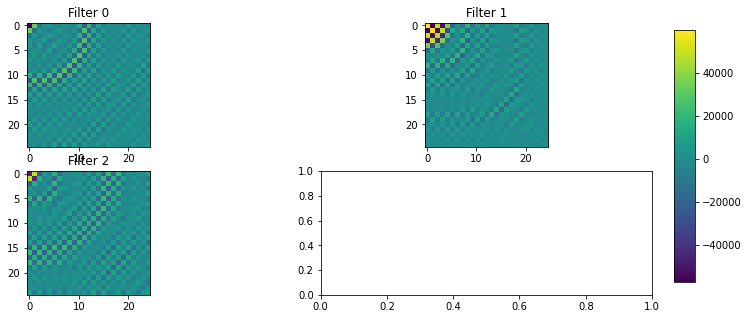

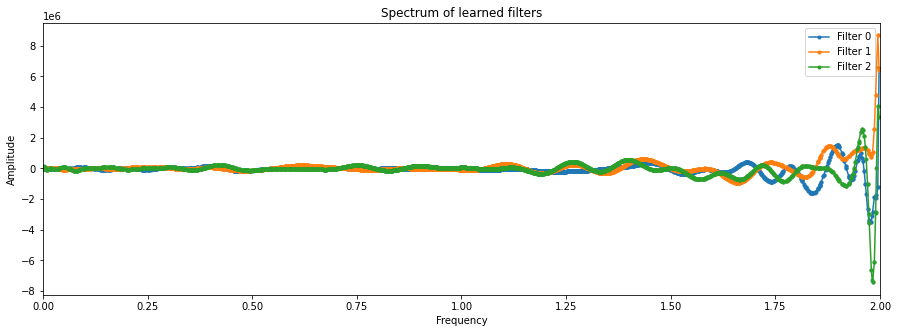

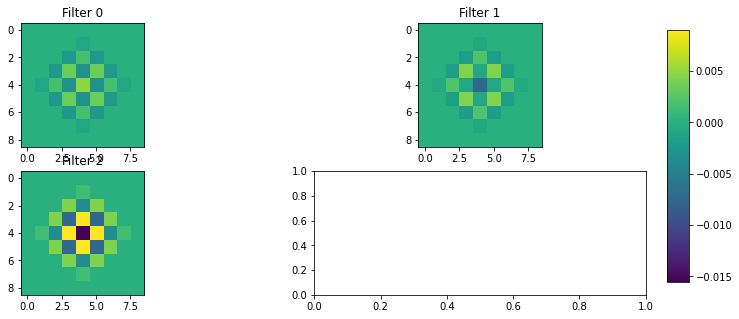

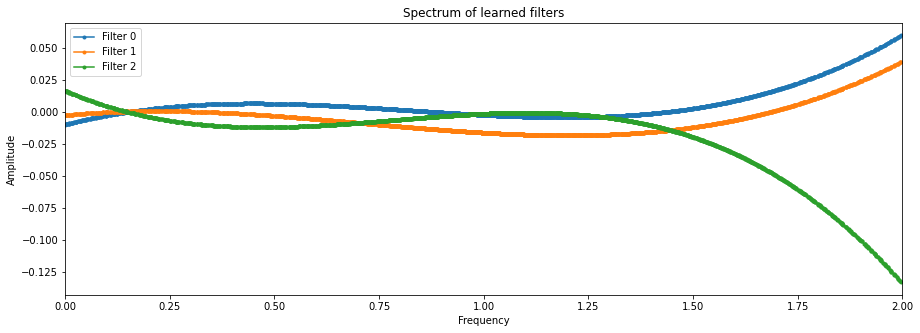

In [60]:
def plot_filters(C, spectrum=False):
    K, F = C.shape
    M, M = L.shape
    m = int(np.sqrt(M))
    X = np.zeros((M,1))
    X[int(m/2*(m+1))] = 1  # Kronecker
    Xt, q = lanczos_basis_eval(L, X, K)
    Z = np.einsum('kmn,kf->mnf', Xt, C)
    Xh = U.T @ X
    Zh = np.tensordot(U.T, Z, (1,0))
    
    pmin = int(m/2) - K
    pmax = int(m/2) + K + 1
    fig, axes = plt.subplots(2,int(np.ceil(F/2)), figsize=(15,5))
    for f in range(F):
        img = Z[:,0,f].reshape((m,m))[pmin:pmax,pmin:pmax]
        im = axes.flat[f].imshow(img, vmin=Z.min(), vmax=Z.max(), interpolation='none')
        axes.flat[f].set_title('Filter {}'.format(f))
    fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.82, 0.16, 0.02, 0.7])
    fig.colorbar(im, cax=cax)
    
    if spectrum:
        ax = plt.figure(figsize=(15,5)).add_subplot(111)
        for f in range(F):
            ax.plot(lamb, Zh[...,f] / Xh, '.-', label='Filter {}'.format(f))
        ax.legend(loc='best')
        ax.set_title('Spectrum of learned filters')
        ax.set_xlabel('Frequency')
        ax.set_ylabel('Amplitude')
        ax.set_xlim(0, lmax)

plot_filters(clf_weights.C, True)
plot_filters(clf_split.C, True)

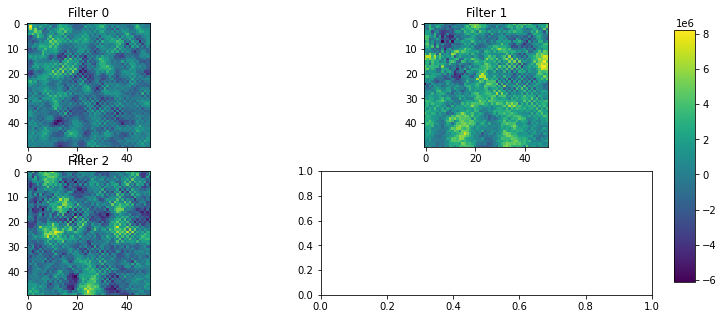

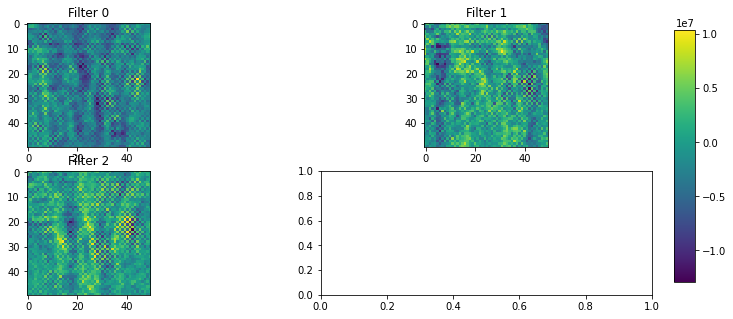

In [61]:
def plot_features(C, x):
    K, F = C.shape
    m = int(np.sqrt(x.shape[0]))
    xt, q = lanczos_basis_eval(L, x, K)
    Z = np.einsum('kmn,kf->mnf', xt, C)
    
    fig, axes = plt.subplots(2,int(np.ceil(F/2)), figsize=(15,5))
    for f in range(F):
        img = Z[:,0,f].reshape((m,m))
        #im = axes.flat[f].imshow(img, vmin=Z.min(), vmax=Z.max(), interpolation='none')
        im = axes.flat[f].imshow(img, interpolation='none')
        axes.flat[f].set_title('Filter {}'.format(f))
    fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.82, 0.16, 0.02, 0.7])
    fig.colorbar(im, cax=cax)

plot_features(clf_weights.C, X[:,[0]])
plot_features(clf_weights.C, X[:,[600]])

In [62]:
def scorer(clf, X, y):
    yest = clf.predict(X).round().squeeze()
    y = y.squeeze()
    yy = np.ones(len(y))
    yy[yest < 0] = -1
    nerrs = np.count_nonzero(y - yy)
    return 1 - nerrs / len(y)

Processing time: 1.609375
L = 191.9703614883967
|dLw| = 6.227136352449263e-09
Processing time: 144.25
L = 183.74418222666122
|dLc| = 0.00123751001259451
|dLw| = 2.432964759877507e-09
Processing time: 281.34375
L = 183.30381471389902
|dLc| = 3.3768785292167304e-16
|dLw| = 0.0023090589822161354
Processing time: 750.671875
L = 184.4878048780507
|dLc| = 5.69156937809311e-17
|dLw| = 0.001400402479728371


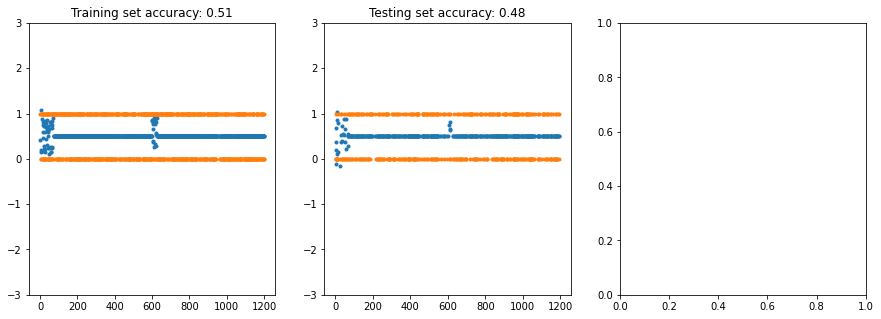

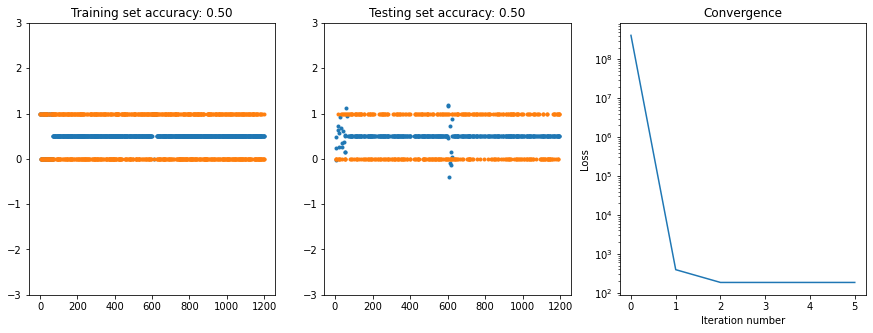

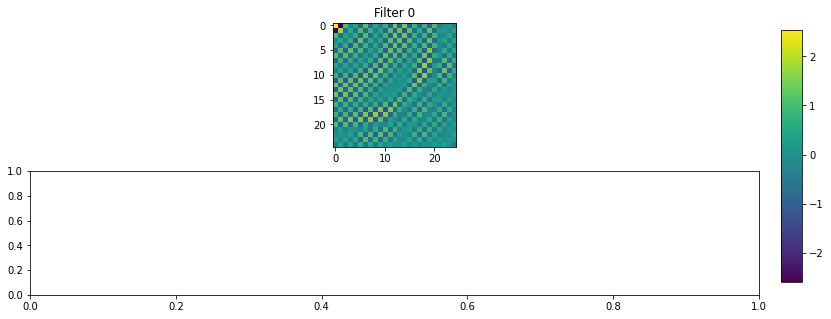

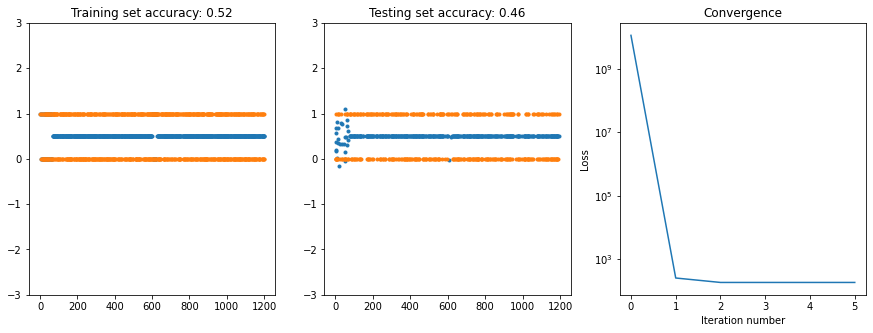

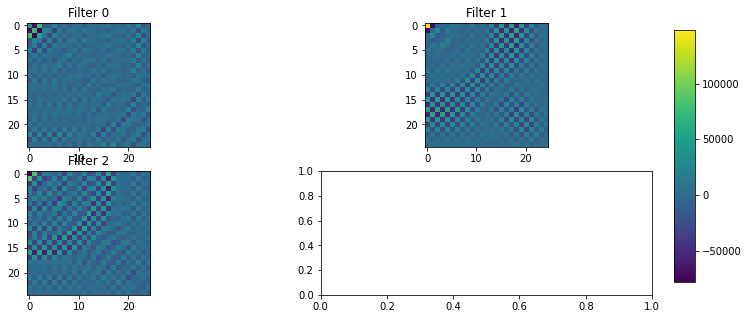

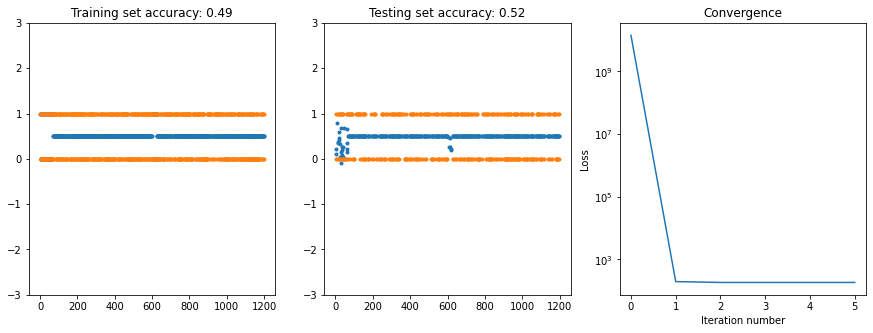

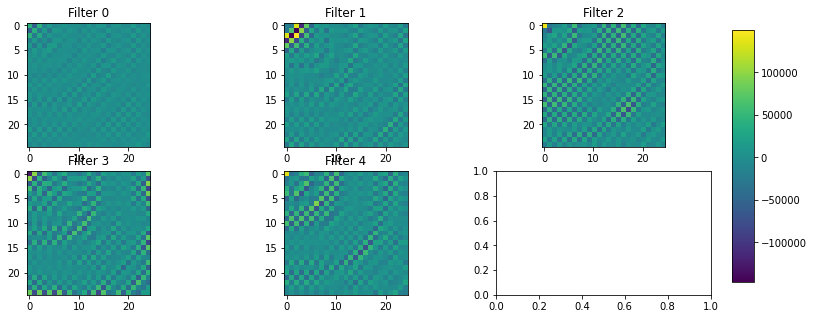

In [63]:
def perf(clf, nfolds=3):
    """Test training accuracy."""
    N = X.shape[1]
    inds = np.arange(N)
    np.random.shuffle(inds)
    inds.resize((nfolds, int(N/nfolds)))
    folds = np.arange(nfolds)
    test = inds[0,:]
    train = inds[folds != 0, :].reshape(-1)
    
    fig, axes = plt.subplots(1,3, figsize=(15,5))
    test_optim(clf, X[:,train], y[train], axes[2])
    
    axes[0].plot(train, clf.predict(X[:,train]), '.')
    axes[0].plot(train, y[train].squeeze(), '.')
    axes[0].set_ylim([-3,3])
    axes[0].set_title('Training set accuracy: {:.2f}'.format(scorer(clf, X[:,train], y[train])))
    axes[1].plot(test, clf.predict(X[:,test]), '.')
    axes[1].plot(test, y[test].squeeze(), '.')
    axes[1].set_ylim([-3,3])
    axes[1].set_title('Testing set accuracy: {:.2f}'.format(scorer(clf, X[:,test], y[test])))
    
    if hasattr(clf, 'C'):
        plot_filters(clf.C)

perf(rls(tauR=1e6))
for F in [1,3,5]:
    perf(gflc_weights(F=F, K=50, tauR=1e4, niter=5, algo='direct'))

In [64]:
def cross_validation(clf, nfolds, nvalidations):
    M, N = X.shape
    scores = np.empty((nvalidations, nfolds))
    for nval in range(nvalidations):
        inds = np.arange(N)
        np.random.shuffle(inds)
        inds.resize((nfolds, int(N/nfolds)))
        folds = np.arange(nfolds)
        for n in folds:
            test = inds[n,:]
            train = inds[folds != n, :].reshape(-1)
            clf.fit(X[:,train], y[train])
            scores[nval, n] = scorer(clf, X[:,test], y[test])
    return scores.mean()*100, scores.std()*100
    #print('Accuracy: {:.2f} +- {:.2f}'.format(scores.mean()*100, scores.std()*100))
    #print(scores)

In [65]:
def test_classification(clf, params, param, values, nfolds=10, nvalidations=1):
    means = []
    stds = []
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    for i,val in enumerate(values):
        params[param] = val
        mean, std = cross_validation(clf(**params), nfolds, nvalidations)
        means.append(mean)
        stds.append(std)
        ax.annotate('{:.2f} +- {:.2f}'.format(mean,std), xy=(i,mean), xytext=(10,10), textcoords='offset points')
    ax.errorbar(np.arange(len(values)), means, stds, fmt='.', markersize=10)
    ax.set_xlim(-.8, len(values)-.2)
    ax.set_xticks(np.arange(len(values)))
    ax.set_xticklabels(values)
    ax.set_xlabel(param)
    ax.set_ylim(50, 100)
    ax.set_ylabel('Accuracy')
    ax.set_title('Parameters: {}'.format(params))

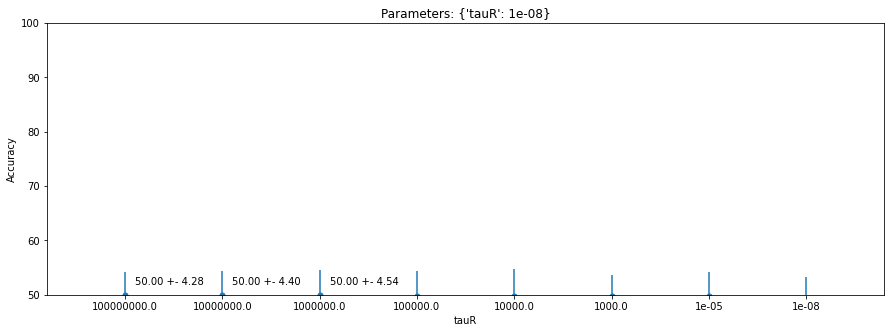

In [66]:
test_classification(rls, {}, 'tauR', [1e8,1e7,1e6,1e5,1e4,1e3,1e-5,1e-8], 10, 10)

In [ ]:
params = {'F':1, 'K':2, 'tauR':1e3, 'niter':5, 'algo':'direct'}
test_classification(gflc_weights, params, 'tauR', [1e8,1e6,1e5,1e4,1e3,1e2,1e-3,1e-8], 10, 10)

In [ ]:
params = {'F':2, 'K':10, 'tauR':1e4, 'niter':5, 'algo':'direct'}
test_classification(gflc_weights, params, 'F', [1,2,3,5])

In [ ]:
params = {'F':2, 'K':4, 'tauR':1e4, 'niter':5, 'algo':'direct'}
test_classification(gflc_weights, params, 'K', [2,3,4,5,8,10,20,30,50,70])